In [1]:
### Import Libraries

import os 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from PIL import Image
from sklearn.model_selection import train_test_split

import gdown
import zipfile

In [2]:
### Set working directory

#Change working directory to the base folder "ML_BarePass"

while os.path.basename(os.getcwd()) != "ML_BarePass":
    os.chdir((os.path.dirname(os.getcwd())))

### Dowload dataset

#### Dowload from drive

In [3]:
dataset_name = "BrainCancer"

In [4]:
# Google Drive file ID
file_id = '1iLuOLiStCg8Nb8cxxaP4vrSj-lo5LqPx'

# Construct the download URL
download_url = f'https://drive.google.com/uc?id={file_id}'

# Define the target directory
target_directory = 'data/raw'

# Ensure the target directory exists
os.makedirs(target_directory, exist_ok=True)

# Specify the output filename with the full path
output_filename = os.path.join(target_directory, f'{dataset_name}.zip')

# Check if the file already exists
if not os.path.exists(output_filename):
    # Download the file
    gdown.download(download_url, output=output_filename, quiet=False)
else:
    print(f"The file '{output_filename}' already exists. Skipping download.")

The file 'data/raw/BrainCancer.zip' already exists. Skipping download.


#### Unzip dataset zip file

In [5]:
output_filename

'data/raw/BrainCancer.zip'

In [6]:
target_directory

'data/raw'

In [7]:
dataset_name

'BrainCancer'

In [8]:
def extract_and_rename(zip_file_path, target_directory, new_folder_name):
    # Ensure the target directory exists
    os.makedirs(target_directory, exist_ok=True)
    
    # Check if the new folder name already exists in the target directory
    new_folder_path = os.path.join(target_directory, new_folder_name)
    if os.path.exists(new_folder_path):
        print(f"{new_folder_name} already exists in target directory: {target_directory}")
        return
    
    # Open the ZIP file
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        # Extract all contents to the target directory
        zip_ref.extractall(target_directory)

        # List all the files and directories in the zip file
        extracted_files = zip_ref.namelist()

        # Assuming there is only one folder, get the first folder name
        folder_name = os.path.basename(extracted_files[0].rstrip('/'))  # Removing trailing '/' if any
        print(f"Extracted folder name: {folder_name}")
    # Find the extracted folder
    extracted_folder_path = os.path.join(target_directory, folder_name)
    
    # Rename the extracted folder to the new folder name
    if os.path.exists(extracted_folder_path):
        os.rename(extracted_folder_path, new_folder_path)
        print(f"Renamed {extracted_folder_path} to {new_folder_path}")
    else:
        print(f"Failed to find extracted folder: {extracted_folder_path}")

In [9]:
extract_and_rename(output_filename, target_directory, dataset_name)

BrainCancer already exists in target directory: data/raw


### Create dataframe

In [10]:
raw_data_dir = os.path.join(target_directory,dataset_name)

# Collect file paths and labels using os.walk()
paths, labels = [], []

if os.path.isdir(raw_data_dir):
    for root, _, files in os.walk(raw_data_dir):
        label = os.path.basename(root)  # The last folder name is the label
        if root != raw_data_dir:  # Ensure we don't include the root folder itself
            paths.extend(os.path.join(root, file) for file in files)
            labels.extend([label] * len(files))



# Create DataFrame
df = pd.DataFrame({'filepath': paths, 'labels': labels})

df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df = df.iloc[:3000]


### Load dataset

In [11]:
from src.data.make_dataset import load_data

In [12]:
dataset = load_data(df)

Loading images and extracting features...
Using device: mps


/Users/minhdang/Library/CloudStorage/OneDrive-Personal/242/ML/ML_BarePass/ml_barepass/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/minhdang/Library/CloudStorage/OneDrive-Personal/242/ML/ML_BarePass/ml_barepass/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/Users/minhdang/Library/CloudStorage/OneDrive-Personal/242/ML/ML_BarePass/ml_barepass/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecat

### Visualize features using PCA and t-NSE

In [28]:
X = dataset['fused_feature']
y = dataset['labels']

In [29]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np

# Assuming X is already loaded and has shape (3000, 87808)
# Assuming y contains the labels corresponding to the cancer types

label_dict = {
    'brain_glioma': 0,
    'brain_menin': 1,
    'brain_tumor': 2
}

# Apply PCA to reduce to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Apply t-SNE to reduce to 2D
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

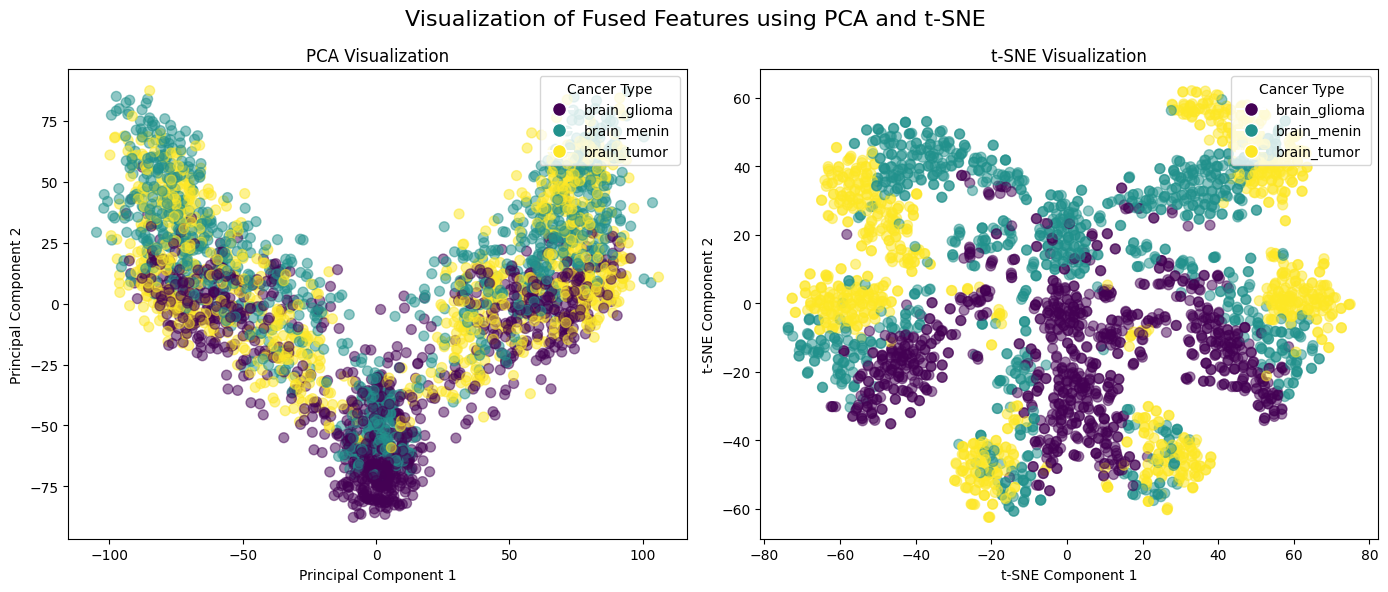

In [30]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot PCA
scatter_pca = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', s=50, alpha=0.5)
axes[0].set_title('PCA Visualization')
axes[0].set_xlabel('Principal Component 1')
axes[0].set_ylabel('Principal Component 2')

# Plot t-SNE
scatter_tsne = axes[1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='viridis', s=50, alpha=0.5)
axes[1].set_title('t-SNE Visualization')
axes[1].set_xlabel('t-SNE Component 1')
axes[1].set_ylabel('t-SNE Component 2')

# Add a title for the entire plot
plt.suptitle('Visualization of Fused Features using PCA and t-SNE', fontsize=16)

# Add legend to both plots using the label_dict
# Map label to cancer type using `label_dict` and colors from `viridis` colormap
handles = [
    plt.Line2D([0], [0], marker='o', color='w', label=labels, markersize=10, 
               markerfacecolor=plt.cm.viridis(int(key) / 2))  # Mapping the numeric label to color
    for labels, key in label_dict.items()
]

# Add the legend to both PCA and t-SNE plots
axes[0].legend(handles=handles, title="Cancer Type", loc='upper right')
axes[1].legend(handles=handles, title="Cancer Type", loc='upper right')

# Adjust layout and show the plot
plt.tight_layout()
# Save the plot as a PNG image
output_image_path = "features.png"
plt.savefig(output_image_path)
plt.show()

### Splitting dataset

In [14]:
import torch
from torch.utils.data import random_split
import numpy as np

def stratified_split(X, y, test_size=0.2, random_seed=42):
    """
    Perform a stratified train-test split using PyTorch.

    Args:
    - X (torch.Tensor): Input feature tensor.
    - y (torch.Tensor): Labels tensor.
    - test_size (float): Proportion of the dataset to allocate to test set.
    - random_seed (int): Seed for reproducibility.

    Returns:
    - X_train, X_test, y_train, y_test: Train-test split tensors.
    """
    torch.manual_seed(random_seed)

    # Convert to NumPy for stratification
    y_np = y
    X_np = X

    # Perform stratified split using sklearn
    from sklearn.model_selection import train_test_split
    X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(
        X_np, y_np, test_size=test_size, random_state=random_seed, stratify=y_np
    )

    # Convert back to PyTorch tensors
    X_train, X_test = torch.tensor(X_train_np, dtype=torch.float32), torch.tensor(X_test_np, dtype=torch.float32)
    y_train, y_test = torch.tensor(y_train_np, dtype=torch.long), torch.tensor(y_test_np, dtype=torch.long)

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = stratified_split(X, y, test_size=0.2)

# Check the sizes of the splits
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

# Class distribution in training and test sets
def print_class_distribution(y, dataset_name):
    unique, counts = torch.unique(y, return_counts=True)
    print(f"\nClass distribution in {dataset_name}:")
    for class_label, count in zip(unique.tolist(), counts.tolist()):
        print(f"Class {class_label}: {count} samples")

print_class_distribution(y_train, "y_train")
print_class_distribution(y_test, "y_test")


Training set size: 2400 samples
Test set size: 600 samples

Class distribution in y_train:
Class 0: 794 samples
Class 1: 830 samples
Class 2: 776 samples

Class distribution in y_test:
Class 0: 199 samples
Class 1: 207 samples
Class 2: 194 samples


In [15]:
import numpy as np

save_dir = os.path.join(os.getcwd(),'data','processed')

train_folder = os.path.join(save_dir,'train')
# val_folder = os.path.join(save_dir,'val')
test_folder = os.path.join(save_dir,'test')

os.makedirs(train_folder,exist_ok=True)
# os.makedirs(val_folder,exist_ok=True)
os.makedirs(test_folder,exist_ok=True)


X_train_file = os.path.join(train_folder,'X_train.npy')
y_train_file = os.path.join(train_folder,'y_train.npy')

# X_val_file = os.path.join(val_folder,'X_val.npy')
# y_val_file = os.path.join(val_folder,'y_val.npy')

X_test_file = os.path.join(test_folder,'X_test.npy')
y_test_file = os.path.join(test_folder,'y_test.npy')

# Save training and test sets
np.save(X_train_file, X_train)
np.save(y_train_file, y_train)

# np.save(X_val_file, X_val)
# np.save(y_val_file, y_val)

np.save(X_test_file, X_test)
np.save(y_test_file, y_test)

### Models

#### Load feautres

In [16]:
import numpy as np
import os
#Change working directory to the base folder "ML_BarePass"

while os.path.basename(os.getcwd()) != "ML_BarePass":
    os.chdir((os.path.dirname(os.getcwd())))

save_dir = os.path.join(os.getcwd(),'data','processed')

train_folder = os.path.join(save_dir,'train')
# val_folder = os.path.join(save_dir,'val')
test_folder = os.path.join(save_dir,'test')

X_train_file = os.path.join(train_folder,'X_train.npy')
y_train_file = os.path.join(train_folder,'y_train.npy')

X_test_file = os.path.join(test_folder,'X_test.npy')
y_test_file = os.path.join(test_folder,'y_test.npy')

# To load the data later
X_train = np.load(X_train_file)
y_train = np.load(y_train_file)

X_test = np.load(X_test_file)
y_test = np.load(y_test_file)

# Check the sizes of the splits
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

# Class distribution in training and test sets
def print_class_distribution(y, dataset_name):
    unique, counts = np.unique(y, return_counts=True)
    print(f"\nClass distribution in {dataset_name}:")
    for class_label, count in zip(unique.tolist(), counts.tolist()):
        print(f"Class {class_label}: {count} samples")

print_class_distribution(y_train, "y_train")
print_class_distribution(y_test, "y_test")


Training set size: 2400 samples
Test set size: 600 samples

Class distribution in y_train:
Class 0: 794 samples
Class 1: 830 samples
Class 2: 776 samples

Class distribution in y_test:
Class 0: 199 samples
Class 1: 207 samples
Class 2: 194 samples


#### Apply scaling and PCA for dimensionality reduction 

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from src.data import BrainCancerDataset
from src.models import *
from src.models.train_model import train_model
from src.models.evaluate_model import evaluate_sklearn_model, evaluate_torch_model
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from torch.utils.data import DataLoader

In [18]:
# Apply StandardScaler & PCA
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

pca = PCA(n_components=0.95)  # Retain 95% variance
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

#### Prepare dataloader

In [19]:
# Convert data into PyTorch DataLoader
batch_size = 32
train_dataset = BrainCancerDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = BrainCancerDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

#### Training and evaluation

In [20]:
result_dict = {

}

##### Decision Tree

In [21]:
# ==========================
# Initialize & Train Model
# ==========================

#Valid options are: decision_tree, naive_bayes, svm, mlp, hmm, bayesian_network

model_name="decision_tree"
param_grid = {
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

max_depth = [5, 10, 15, 25, 30]
min_samples_split = [2, 5, 10, 15, 100]
min_samples_leaf = [1, 2, 5, 10]
max_features = [1, 2, 5, 10]
model = load_model(model_name, random_state = 42)
device = torch.device("cpu")
print(f"Training {model_name} model...")
train_model(model, train_loader,hyper_tune=True,param_grid=param_grid,device=device)
# train_model(model, train_loader, hyper_tune=False)

DecisionTreeClassifier(random_state=42)
Training decision_tree model...
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2}
DecisionTreeClassifier training complete.
Log Loss: 0.2251, Training Accuracy: 0.9062


Classification Report:
              precision    recall  f1-score   support

brain_glioma       0.52      0.72      0.61       199
 brain_menin       0.44      0.17      0.25       207
 brain_tumor       0.61      0.76      0.67       194

    accuracy                           0.55       600
   macro avg       0.52      0.55      0.51       600
weighted avg       0.52      0.55      0.50       600

Accuracy: 0.5450
Precision: 0.5222
Recall: 0.5450
F1 Score: 0.5049


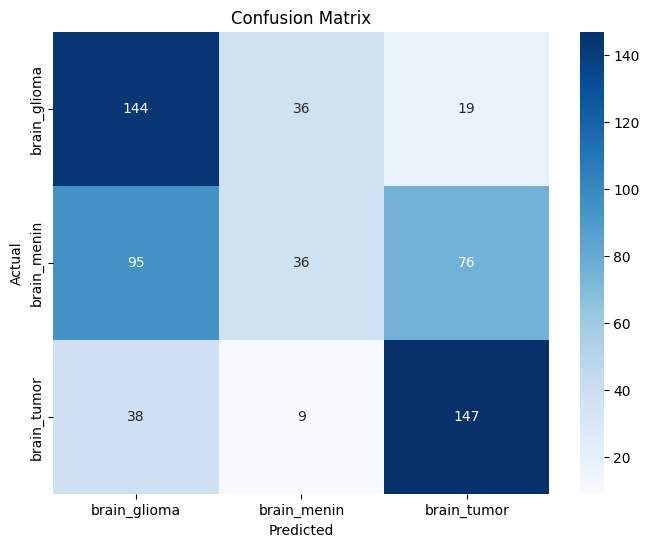

In [22]:
result_dict[model_name] = evaluate_sklearn_model(model,X_test,y_test,True)

##### ANN/MLP

In [23]:
# ==========================
# Initialize & Train Model
# ==========================

#Valid options are: decision_tree, naive_bayes, svm, mlp, hmm, bayesian_network

model_name="mlp"
model = load_model(model_name,input_dim = X_train.shape[1], num_classes=3)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
if torch.cuda.is_available():
        device = torch.device("cuda")
elif torch.backends.mps.is_available():
        device = torch.device("mps")
else:
        device = torch.device("cpu")
# Train the model
print(f"Training {model_name} model...")
train_model(model, train_loader, criterion, optimizer, device, epochs=100)

Training mlp model...
Epoch [10/100] - Loss: 0.0004, Accuracy: 1.0000
Epoch [20/100] - Loss: 0.0001, Accuracy: 1.0000
Epoch [30/100] - Loss: 0.0000, Accuracy: 1.0000
Epoch [40/100] - Loss: 0.0000, Accuracy: 1.0000
Epoch [50/100] - Loss: 0.0000, Accuracy: 1.0000
Epoch [60/100] - Loss: 0.0000, Accuracy: 1.0000
Epoch [70/100] - Loss: 0.0000, Accuracy: 1.0000
Epoch [80/100] - Loss: 0.0000, Accuracy: 1.0000
Epoch [90/100] - Loss: 0.0000, Accuracy: 1.0000
Epoch [100/100] - Loss: 0.0000, Accuracy: 1.0000


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       199
           1       0.98      0.96      0.97       207
           2       0.95      0.98      0.97       194

    accuracy                           0.98       600
   macro avg       0.98      0.98      0.98       600
weighted avg       0.98      0.98      0.98       600

Accuracy: 0.9783
F1 Score: 0.9784
Recall: 0.9783
Precision: 0.9787


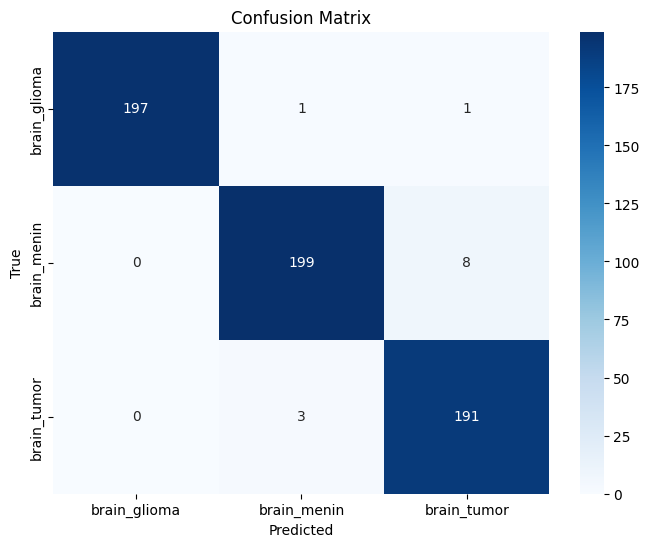

In [24]:
result_dict[model_name]=evaluate_torch_model(model, test_loader,device,True)

##### Naive Bayes

In [25]:
# ==========================
# Initialize & Train Model
# ==========================

#Valid options are: decision_tree, naive_bayes, svm, mlp, hmm, bayesian_network

model_name="naive_bayes"
model = load_model(model_name)
device = torch.device("cpu")
print(f"Training {model_name} model...")
train_model(model, train_loader, hyper_tune=False)

GaussianNB()
Training naive_bayes model...
GaussianNB training complete.
Log Loss: 0.0000, Training Accuracy: 1.0000


Classification Report:
              precision    recall  f1-score   support

brain_glioma       0.48      0.46      0.47       199
 brain_menin       0.36      0.72      0.48       207
 brain_tumor       0.00      0.00      0.00       194

    accuracy                           0.40       600
   macro avg       0.28      0.39      0.32       600
weighted avg       0.29      0.40      0.32       600

Accuracy: 0.4017
Precision: 0.2854
Recall: 0.4017
F1 Score: 0.3234


/Users/minhdang/Library/CloudStorage/OneDrive-Personal/242/ML/ML_BarePass/ml_barepass/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/minhdang/Library/CloudStorage/OneDrive-Personal/242/ML/ML_BarePass/ml_barepass/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/minhdang/Library/CloudStorage/OneDrive-Personal/242/ML/ML_BarePass/ml_barepass/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being s

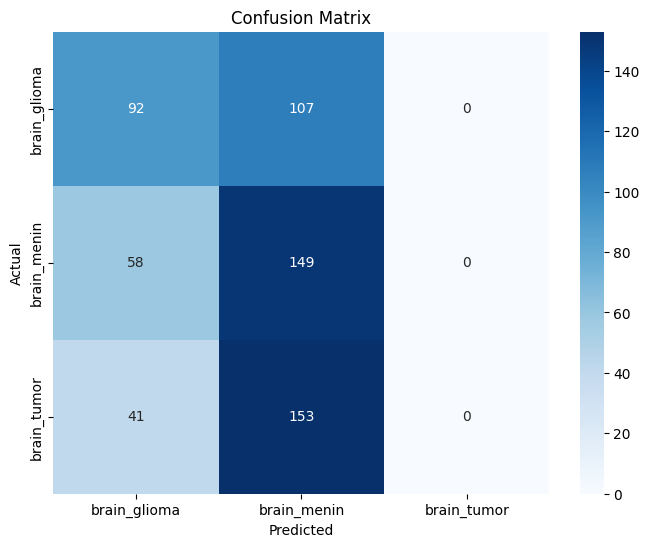

In [26]:
result_dict[model_name] = evaluate_sklearn_model(model,X_test,y_test,True)

##### Bayesian Networks

In [27]:
# ==========================
# Initialize & Train Model
# ==========================

#Valid options are: decision_tree, naive_bayes, svm, mlp, hmm, bayesian_network

model_name="bayesian_network"
model = load_model(model_name,input_dim = X_train.shape[1], num_classes=3)
criterion = None
optimizer = None
if torch.cuda.is_available():
        device = torch.device("cuda")
elif torch.backends.mps.is_available():
        device = torch.device("mps")
else:
        device = torch.device("cpu")
# Train the model
print(f"Training {model_name} model...")
train_model(model, train_loader, criterion, optimizer, device,epochs=100)

Training bayesian_network model...
Epoch [10/100] - Loss: 0.1843
Epoch [20/100] - Loss: 0.0337
Epoch [30/100] - Loss: 0.0297
Epoch [40/100] - Loss: 7734.5958
Epoch [50/100] - Loss: 1484356.4372
Epoch [60/100] - Loss: 944919.8141
Epoch [70/100] - Loss: 3801619.3091
Epoch [80/100] - Loss: 1222456.1300
Epoch [90/100] - Loss: 4004273.3202
Epoch [100/100] - Loss: 1551558.2294
Training complete. Model saved.


Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.83      0.85       199
           1       0.88      0.83      0.85       207
           2       0.81      0.91      0.86       194

    accuracy                           0.85       600
   macro avg       0.85      0.85      0.85       600
weighted avg       0.86      0.85      0.85       600

Accuracy: 0.8533
F1 Score: 0.8532
Recall: 0.8533
Precision: 0.8556


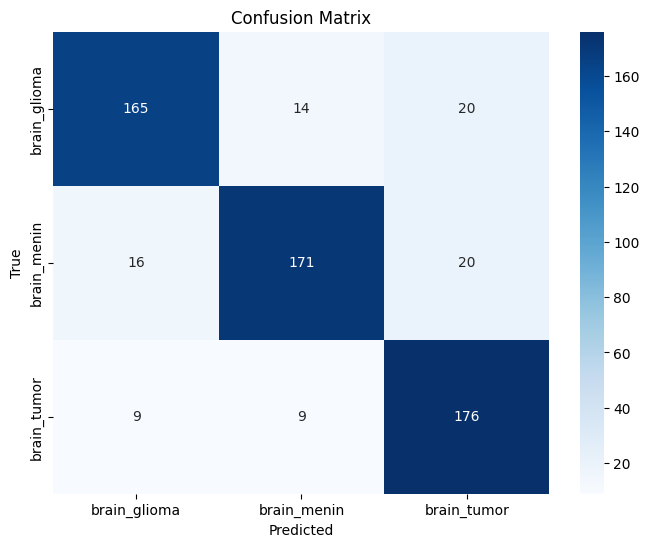

In [28]:
result_dict[model_name]=evaluate_torch_model(model, test_loader,device,True)

##### HMM

In [29]:
# ==========================
# Initialize & Train Model
# ==========================

#Valid options are: decision_tree, naive_bayes, svm, mlp, hmm, bayesian_network

model_name="hmm"
model = load_model(model_name,input_dim = X_train.shape[1], num_classes=3)
criterion = None
optimizer = None
if torch.cuda.is_available():
        device = torch.device("cuda")
elif torch.backends.mps.is_available():
        device = torch.device("mps")
else:
        device = torch.device("cpu")
# Train the model
print(f"Training {model_name} model...")
train_model(model, train_loader, criterion, optimizer, device,epochs=100)

Training hmm model...
Epoch [10/100] - Adjusted Loss: 0.0000
Epoch [20/100] - Adjusted Loss: 0.0000
Epoch [30/100] - Adjusted Loss: 0.0000
Epoch [40/100] - Adjusted Loss: 0.0000
Epoch [50/100] - Adjusted Loss: 0.0000
Epoch [60/100] - Adjusted Loss: 0.0000
Epoch [70/100] - Adjusted Loss: 0.0000
Epoch [80/100] - Adjusted Loss: 0.0000
Epoch [90/100] - Adjusted Loss: 0.0000
Epoch [100/100] - Adjusted Loss: 0.0000


Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.87      0.91       199
           1       0.87      0.84      0.85       207
           2       0.83      0.93      0.88       194

    accuracy                           0.88       600
   macro avg       0.88      0.88      0.88       600
weighted avg       0.88      0.88      0.88       600

Accuracy: 0.8800
F1 Score: 0.8804
Recall: 0.8800
Precision: 0.8839


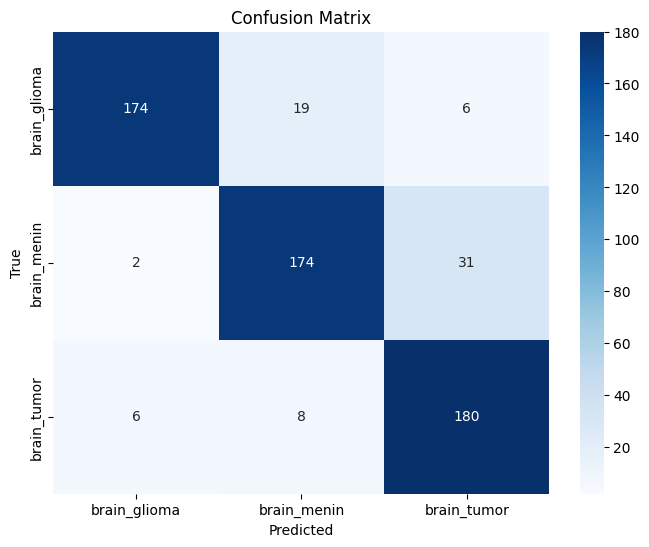

In [30]:
result_dict[model_name]=evaluate_torch_model(model, test_loader,device,True)

##### SVM

In [31]:
# ==========================
# Initialize & Train Model
# ==========================

#Valid options are: decision_tree, naive_bayes, svm, mlp, hmm, bayesian_network

model_name="svm"
param_grid = {'C': [0.001, 0.01, 0.05, 0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf','linear'],
             }
model = load_model(model_name, probability=True, random_state = 42)
device = torch.device("cpu")
print(f"Training {model_name} model...")
train_model(model, train_loader, hyper_tune=True, param_grid=param_grid)

SVC(probability=True, random_state=42)
Training svm model...
Best parameters found: {'C': 0.001, 'gamma': 1, 'kernel': 'linear'}
SVC training complete.
Log Loss: 1.3194, Training Accuracy: 1.0000


Classification Report:
              precision    recall  f1-score   support

brain_glioma       0.62      0.94      0.75       199
 brain_menin       0.66      0.64      0.65       207
 brain_tumor       0.86      0.44      0.58       194

    accuracy                           0.68       600
   macro avg       0.71      0.67      0.66       600
weighted avg       0.71      0.68      0.66       600

Accuracy: 0.6750
Precision: 0.7126
Recall: 0.6750
F1 Score: 0.6611


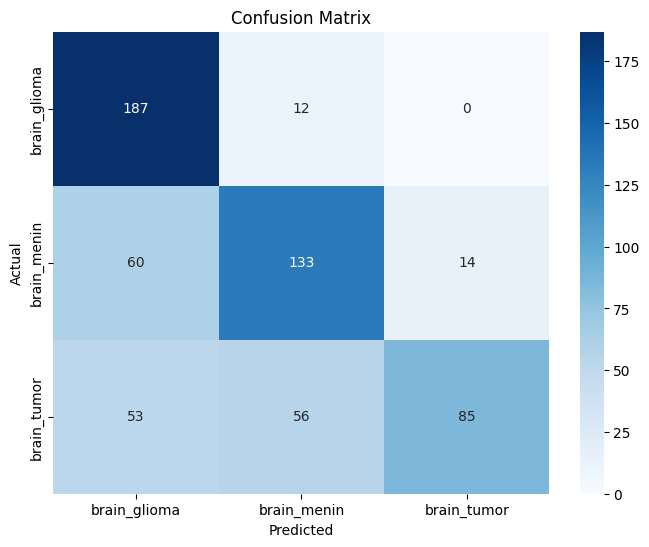

In [32]:
result_dict[model_name] = evaluate_sklearn_model(model,X_test,y_test,True)

#### Performance comparision

In [32]:
## This is our result but your result when running might be different
# result_dict = {'decision_tree': {'Accuracy': 0.545,
#   'Precision': 0.5221570645741962,
#   'Recall': 0.545,
#   'F1': 0.5049497918433429},
#  'mlp': {'Accuracy': 0.9783333333333334,
#   'Precision': 0.9786519704433497,
#   'Recall': 0.9783333333333334,
#   'F1': 0.9783796391132654},
#  'naive_bayes': {'Accuracy': 0.40166666666666667,
#   'Precision': 0.2854402684792859,
#   'Recall': 0.40166666666666667,
#   'F1': 0.3233779831279831},
#  'bayesian_network': {'Accuracy': 0.8533333333333334,
#   'Precision': 0.8555810440572603,
#   'Recall': 0.8533333333333334,
#   'F1': 0.8531953652975426},
#  'hmm': {'Accuracy': 0.88,
#   'Precision': 0.8839473934827811,
#   'Recall': 0.88,
#   'F1': 0.8804160172604016},
#  'svm': {'Accuracy': 0.675,
#   'Precision': 0.7126318985878688,
#   'Recall': 0.675,
#   'F1': 0.6611098498610015}}

result_dict

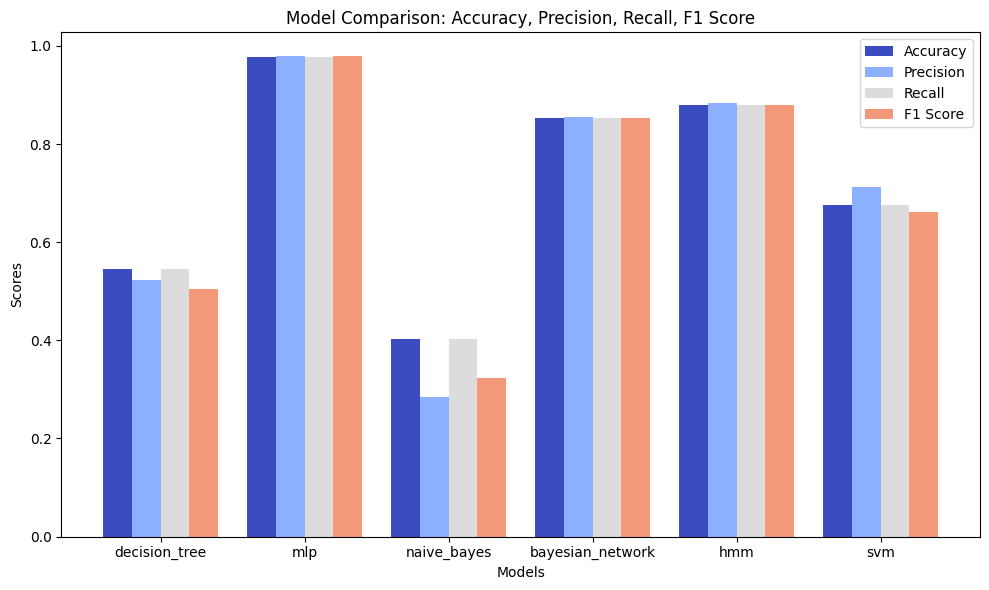

In [33]:
import matplotlib.pyplot as plt

# Extract the metrics from result_dict and prepare them for plotting
metrics = result_dict

# Create a list of model names and their respective metrics
model_names = list(metrics.keys())
accuracy_values = [metrics[model]['Accuracy'] for model in model_names]
precision_values = [metrics[model]['Precision'] for model in model_names]
recall_values = [metrics[model]['Recall'] for model in model_names]
f1_values = [metrics[model]['F1'] for model in model_names]

# Set up the figure and axis with the "coolwarm" colormap
fig, ax = plt.subplots(figsize=(10, 6))

# Define bar width and position for grouped bars
bar_width = 0.2
index = np.arange(len(model_names))

# Choose a coolwarm colormap and generate colors for each metric
cmap = plt.get_cmap("coolwarm")
colors = [cmap(i / 4) for i in range(4)]  # Get 4 colors for 4 metrics

# Plot grouped bars with coolwarm colors
bars1 = ax.bar(index, accuracy_values, bar_width, label='Accuracy', color=colors[0])
bars2 = ax.bar(index + bar_width, precision_values, bar_width, label='Precision', color=colors[1])
bars3 = ax.bar(index + 2 * bar_width, recall_values, bar_width, label='Recall', color=colors[2])
bars4 = ax.bar(index + 3 * bar_width, f1_values, bar_width, label='F1 Score', color=colors[3])

# Set labels and title
ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Model Comparison: Accuracy, Precision, Recall, F1 Score')
ax.set_xticks(index + 1.5 * bar_width)  # Position the model names at the center of the bars
ax.set_xticklabels(model_names)
ax.legend()

# Display the plot
plt.tight_layout()
plt.savefig("ModelCompare.png")
plt.show()